# Домашнее задание №5

Задание выполнил(а): `Соломенцев Александр`

### Общая информация

__Дедлайн:__ 27.02.2022 23:30


### О задании

Часть 1 содержит практическое задание на применение метода главных компонент.

Часть 2 содержит практическое задание на применение метода One-Class SVM.


### Оценивание и штрафы


#### 1. Метод главных компонент [5 баллов]
* [Задание 1](#task1) [2 балла]
* [Задание 2](#task2) [2 балл]
* [Задание 3](#task3) [1 балл]

#### 2. One-Class SVM [5 баллов]
* [Задание 1](#task2_1) [1 балл]
* [Задание 2](#task2_2) [1 балл]
* [Задание 3](#task2_3) [3 балла]

Итоговая оценка за домашнюю работу равна сумме набранных баллов.

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 0.25 балла в день (от оценки в 10 бальной шкале), но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/course/890). 

In [1]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

np.random.seed(0)

# Часть 1. Детектирование аномалий на основе метода главных компонент
В файле Abilebe.mat представлены данные о трафике (количество байт в единицу времени) в сети Abilene для трех недель. Загрузим данные и посмотрим на ключи словаря.

In [2]:
data = io.loadmat('Abilene.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'odnames', 'X2', 'utc2', 'X3', 'utc3', 'X4', 'utc4'])

Словарь содержит:
+ матрицы X2, X3 и X4 с информацией о трафике между 121 парами “адресат-получатель” для каждой из трех недель
+ odnames с названиями всех пар “адресат-получатель”
+ вектора utc2; utc3, и utc4, содержащие моменты времени в формате UTC (в секундах), для которых были измерены значения трафика между рассмотренными парами “адресат-получатель”

Нас интересует информация о трафике: хотелось бы реагировать на аномальные события в сети. Давайте попробуем оценить визуально.

In [3]:
X2 = data['X2']
X3 = data['X3']
X4 = data['X4']

In [4]:
X2.shape, data['odnames'].shape

((2016, 121), (121, 1))

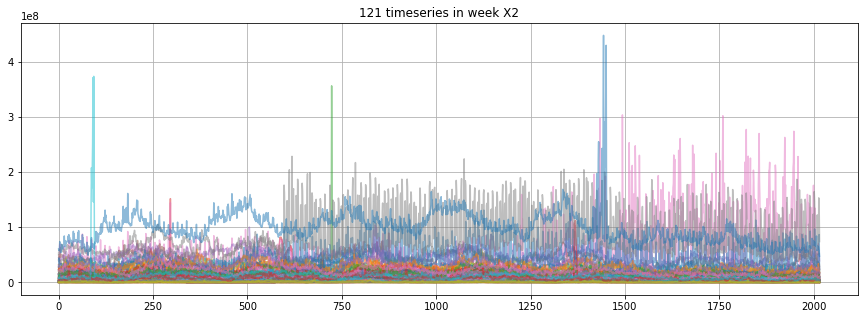

In [5]:
plt.figure(figsize=(15,5))
plt.plot(X2, alpha=0.5);
plt.title('121 timeseries in week X2')
plt.grid(True)

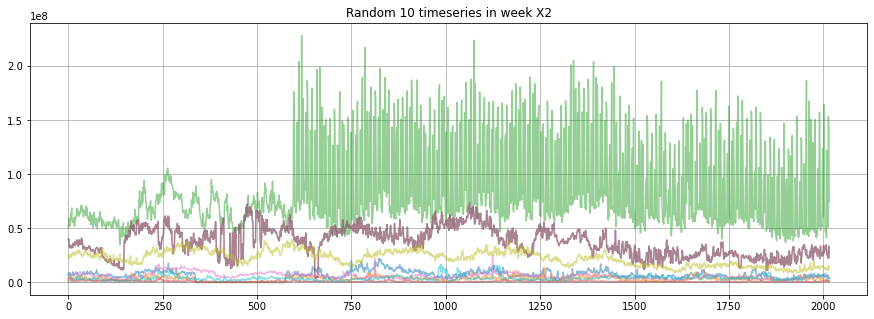

In [6]:
idx = np.random.randint(low= 0, high= 121, size= 10)
plt.figure(figsize=(15,5))
plt.plot(X2[:,idx], alpha=0.5);
plt.title('Random 10 timeseries in week X2')
plt.grid(True)

У нас слишком много рядов (высокая размерность данных 121) и их диапозоны значений довольно разные! Однако, видна какая-то структура. Это дает надежду на успешное снижение размерности задачи методом главных компонент. Предлагается использовать следующий алгоритм:
1. Оценить операторы сжатия и восстановления по компонентам второй недели (тренеровочная выборка)
2. Критерий аномальности наблюдения: слишком большая ошибка восстановления после сжатия 

### Задание 1 [2 балла] <a id="task1"></a>
Вспомнить детали реализации алгоритма главных компонент (https://arxiv.org/pdf/1404.1100.pdf) и получить оператор сжатия.

Оценки будут производиться по главным компонентам **второй** недели

In [7]:
X2_mean = X2.mean(axis= 0) # средние по каждому ряду (в данном случае столбцу)
U, s, V_T = np.linalg.svd((X2 - X2_mean).T) # U - m x m, s – m, V – n x n
X2_based_pc = U

Подсчитаем метрику $\rho := $ какую долю дисперсии данных в каждую из трех недель (по отдельности) объясняют первые $d$ главных компонент, оценненые по первой неделе. 

Пусть 
 - $X$ матрица $121 \times 2016$ для которой нужно оценить такую метрику
 - $\overline{X}$ вектор средних по строкам
 - $U$ первые $d$ главных компонент, оценненые по первой неделе
 - $Z(X) = U^T(X2 - \overline{X2})$ преобразование сжатия 
 
Тогда 

$$
\rho(X) = \dfrac{\operatorname{trace}(Z - \overline{Z})(Z - \overline{Z})^T}{\operatorname{trace}(X - \overline{X})(X - \overline{X})^T} 
$$
 

Преобразование сжатия:

In [34]:
def compression_operator(X, mean_pc, based_pc, number_pc):  # X - n x m
    # your code here
    Z = based_pc[:, :number_pc].T @ (X - mean_pc).T
    return Z

def rho(X, mean_pc, based_pc, number_pc): # X - n x m
    # your code here
    Z = compression_operator(X, mean_pc, based_pc, number_pc)
    if number_pc == 1:
        explained_var = Z.var() # your code here
    else:
        explained_var = 1 / X.shape[0] * np.trace((Z - Z.mean(axis= 1)[:, None]) @ (Z - Z.mean(axis= 1)[:, None]).T ) # your code here
    total_var = 1 / X.shape[0] * np.trace((X - X.mean(axis= 0)).T @ (X - X.mean(axis= 0)))  # your code here
    return explained_var / total_var

In [38]:
X2_comp = compression_operator(X2, X2_mean, X2_based_pc, 20)

In [39]:
X2_comp.shape

(20, 2016)

In [41]:
X2_based_pc[:, :20].T.shape

(20, 121)

### Задание 2 [2 балла] <a id="task2"></a>
Подсчитать, какую долю дисперсии данных в каждую из трех
недель (по отдельности) объясняют первые d главных компонент (график зависимости $\rho$ от d), если главные компоненты были оценены по данным первой недели.

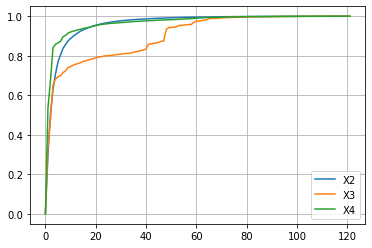

In [36]:
X2_var, = plt.plot([rho(X2, X2_mean, X2_based_pc, i) for i in np.arange(X2.shape[1] + 1)], label='X2') # your code here
X3_var, = plt.plot([rho(X3, X2_mean, X2_based_pc, i) for i in np.arange(X2.shape[1] + 1)], label='X3') # your code here
X4_var, = plt.plot([rho(X4, X2_mean, X2_based_pc, i) for i in np.arange(X2.shape[1] + 1)], label='X4') # your code here

plt.legend(handles=[X2_var, X3_var, X4_var], loc='best')
plt.axis('tight');
plt.grid();

Выпишем преобразование восстановления для $X$:

$$\hat{X} = \overline{X2} + UZ(X)$$

где $Z(X)$ - преобразование сжатия из прошлого задания.

In [44]:
def decompression_operator(compressed_X, mean_pc, based_pc, number_pc):
    # your code here
    X_hat = mean_pc[:, None] + based_pc[:, :number_pc] @ compressed_X
    
    return X_hat # X - m x n

In [45]:
X_hat = decompression_operator(X2_comp, X2_mean, X2_based_pc, 20)

In [46]:
X_hat.shape

(121, 2016)

In [49]:
def residual_matrix(X, mean_pc, based_pc, number_pc): # X - n x m
    # your code here
    compressed_X = compression_operator(X, mean_pc, based_pc, number_pc)
    X_hat = decompression_operator(compressed_X, mean_pc, based_pc, number_pc) # X_hat - m x n
    E = X.T - X_hat
    
    return E

In [50]:
E_X2 = residual_matrix(X2, X2_mean, X2_based_pc, 20)

In [51]:
E_X2.shape

(121, 2016)

### Задание 3 [2 балла] <a id="task3"></a>
Нарисовать график зависимости статистики $Q = (x - \hat x)^T(x - \hat x)$ ( https://www.ltu.se/cms_fs/1.51590!/pca_part%201_jackson_1980.pdf, интересующая формула: 31) от времени для каждой из трех недель по отдельности, при этом главные компоненты оценивать по данным первой недели, параметр d выбрать по результатам анализа зависимости доли диперсии от значения d для данных первой
недели.

*Заметим*: Статистика $Q$ тогда в момент времени $t$ это квадрат нормы строки $t$ матрицы $X-\hat{X}$

In [59]:
def q_stat(residuals, moment):
    # your code here
    Q = residuals[:, moment].T @ residuals[:, moment]
    
    return Q

In [64]:
q_stat(E_X2, 1)

213741203328084.3

In [63]:
np.linalg.norm(E_X2[:, 1]) ** 2

213741203328084.28

Зафиксируем число компонет, с которым будем работать:

In [65]:
def broken_stick_pc_number_select(X): # X - n x m
    X_mean = X.mean(axis= 0) # your code here
    U, s, V_T = np.linalg.svd((X - X_mean).T) # your code here
    
    s = s ** 2 / float(np.sum(s ** 2))
    broken_stick = np.array([np.sum(1.0 / np.arange(1, 122)[i:]) for i in range(121)]) / 121.0
    return s > broken_stick

In [66]:
broken_stick_pc_number_select(X2)

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [74]:
np.argwhere(broken_stick_pc_number_select(X2) == False)[0]

array([7])

Выберем сколько будем использовать главных компонент матрицы $X2$. Посмотрим, сколько процентов дисперсии в $X2$ неделе они объясняют:

In [76]:
pc_const = np.argwhere(broken_stick_pc_number_select(X2) == False)[0][0] # your code here
np.sum(s[:pc_const] ** 2) / float(np.sum(s ** 2))

0.8374392213328565

Рассчитаем матрицу остатков для каждой из недели:

In [78]:
X2_resid = residual_matrix(X2, X2_mean, X2_based_pc, pc_const) # your code here
X3_resid = residual_matrix(X3, X2_mean, X2_based_pc, pc_const) # your code here
X4_resid = residual_matrix(X4, X2_mean, X2_based_pc, pc_const) # your code here

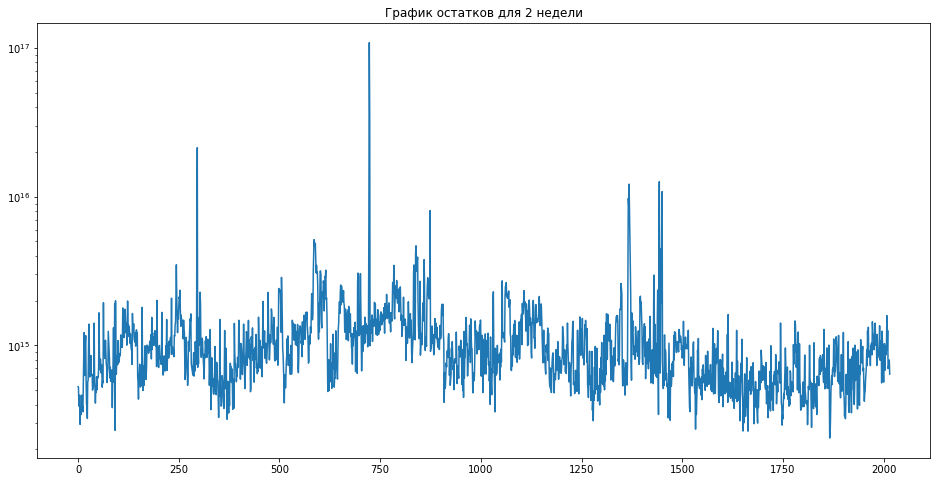

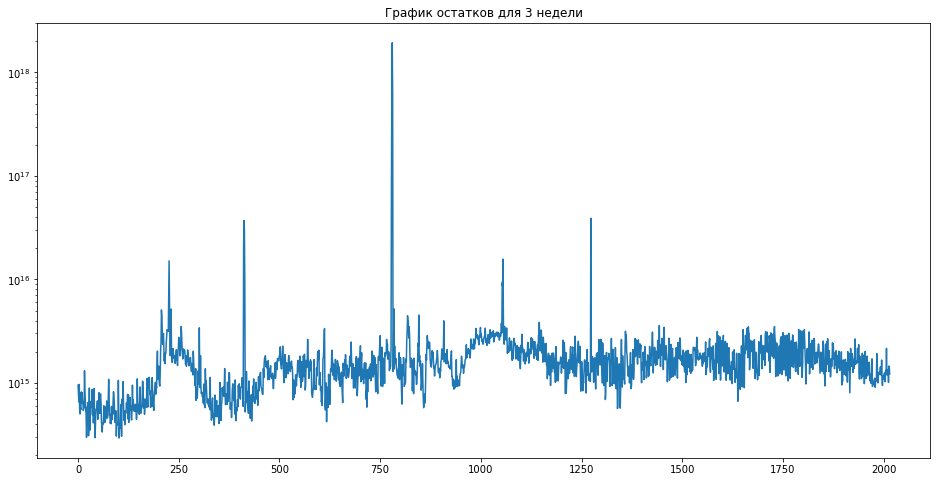

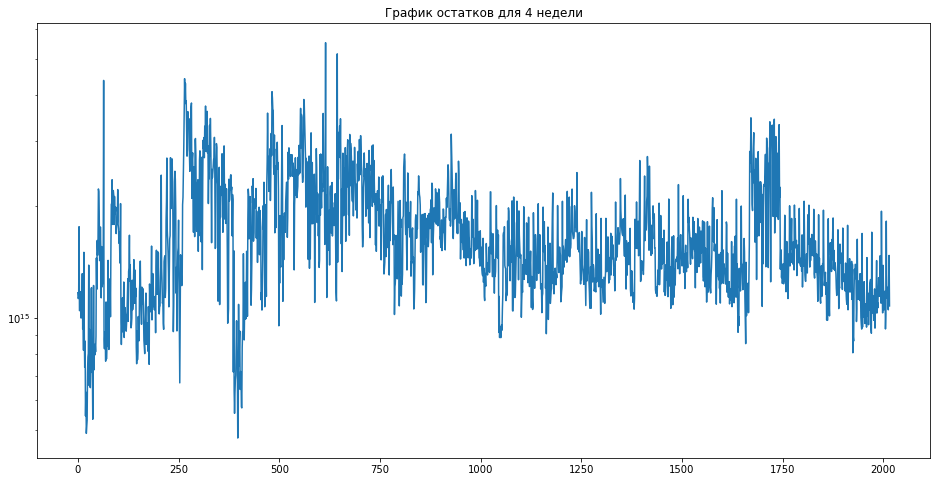

In [81]:
for label, X in enumerate([X2_resid, X3_resid, X4_resid]):
    fig, ax = plt.subplots(figsize= (16,8))
    ax.set_title(f"График остатков для {label + 2} недели")
    ax.set_yscale('log')
    ax.plot([q_stat(X, i) for i in np.arange(X.shape[1])])
    
    plt.show()

### Задание 4 [2 балла] <a id="task4"></a>
Теперь достаточно объявлять тревогу для наблюдения с "большим" полученным остатком (ошибкой восстановления). Однако, здесь требуется уточнить, что такое "большим"?
Один из возможных подходов к определению этого уровня статистически, предполагая нормальное распределение рассчитываемой статистики, нам остается задать уровень значимости $\alpha$. Расчет статистики реализован в функции q_critical. Математические детали можно прочитать здесь: ( https://www.ltu.se/cms_fs/1.51590!/pca_part%201_jackson_1980.pdf, интересующая формула: 33).  

Вам необходимо взять параметр $\alpha$ равным 0.05 и 0.01, привести на рисунках значение попрога $Q_\alpha$ (изобразив константной линией) и рассчитать число аномалий для каждой недели.

In [82]:
def q_critical(X, number_pc, alpha):
    X_mean = X.mean(axis=0)
    
    w, v = np.linalg.eig(np.cov((X - X_mean).T))
    l = -np.sort(-w)[number_pc:]
    
    theta_one = l.sum() # your code here
    theta_two = (l ** 2).sum() # your code here
    theta_three = (l ** 3).sum() # your code here

    h = 1 - (2 * theta_one * theta_three) / (3 * theta_two ** 2) # your code here
    
    if h > 0:
        c_alpha = stats.norm.ppf(1 - alpha) 
    else:
        c_alpha = stats.norm.ppf(alpha) 
        
    inside_brackets = (c_alpha * np.sqrt(2 * theta_two * h ** 2)) / theta_one \
                      + (theta_two * h * ( h - 1)) / (theta_one ** 2) \
                      + 1 # your code here
    
    return theta_one * np.power(inside_brackets, 1/h) 

Добавим критические значения статистики и рассмотим график для каждой недели отдельно:

In [98]:
def q_plot(X, X_resid, number_pc):
    f, axarr = plt.subplots(2, sharex=True, figsize=(40, 20))
    
    axarr[0].set_yscale('log')
    axarr[0].plot([q_stat(X_resid, t) for t in range(2016)])
    axarr[0].axhline(y=q_critical(X, number_pc, 0.01) , xmin=0, xmax=2016, linewidth=2, color = 'r')
    axarr[0].axhline(y=q_critical(X, number_pc, 0.05) , xmin=0, xmax=2016, linewidth=2, color = 'g')
    axarr[0].axis('tight')
    
    axarr[1].plot(X);
    axarr[1].axis('tight')

Выведем графики остатков c линиями $Q_{\alpha}$ (в логарифмической шкале)  и графики процессов (ocь времени совпадет):

### Для недели $X2$

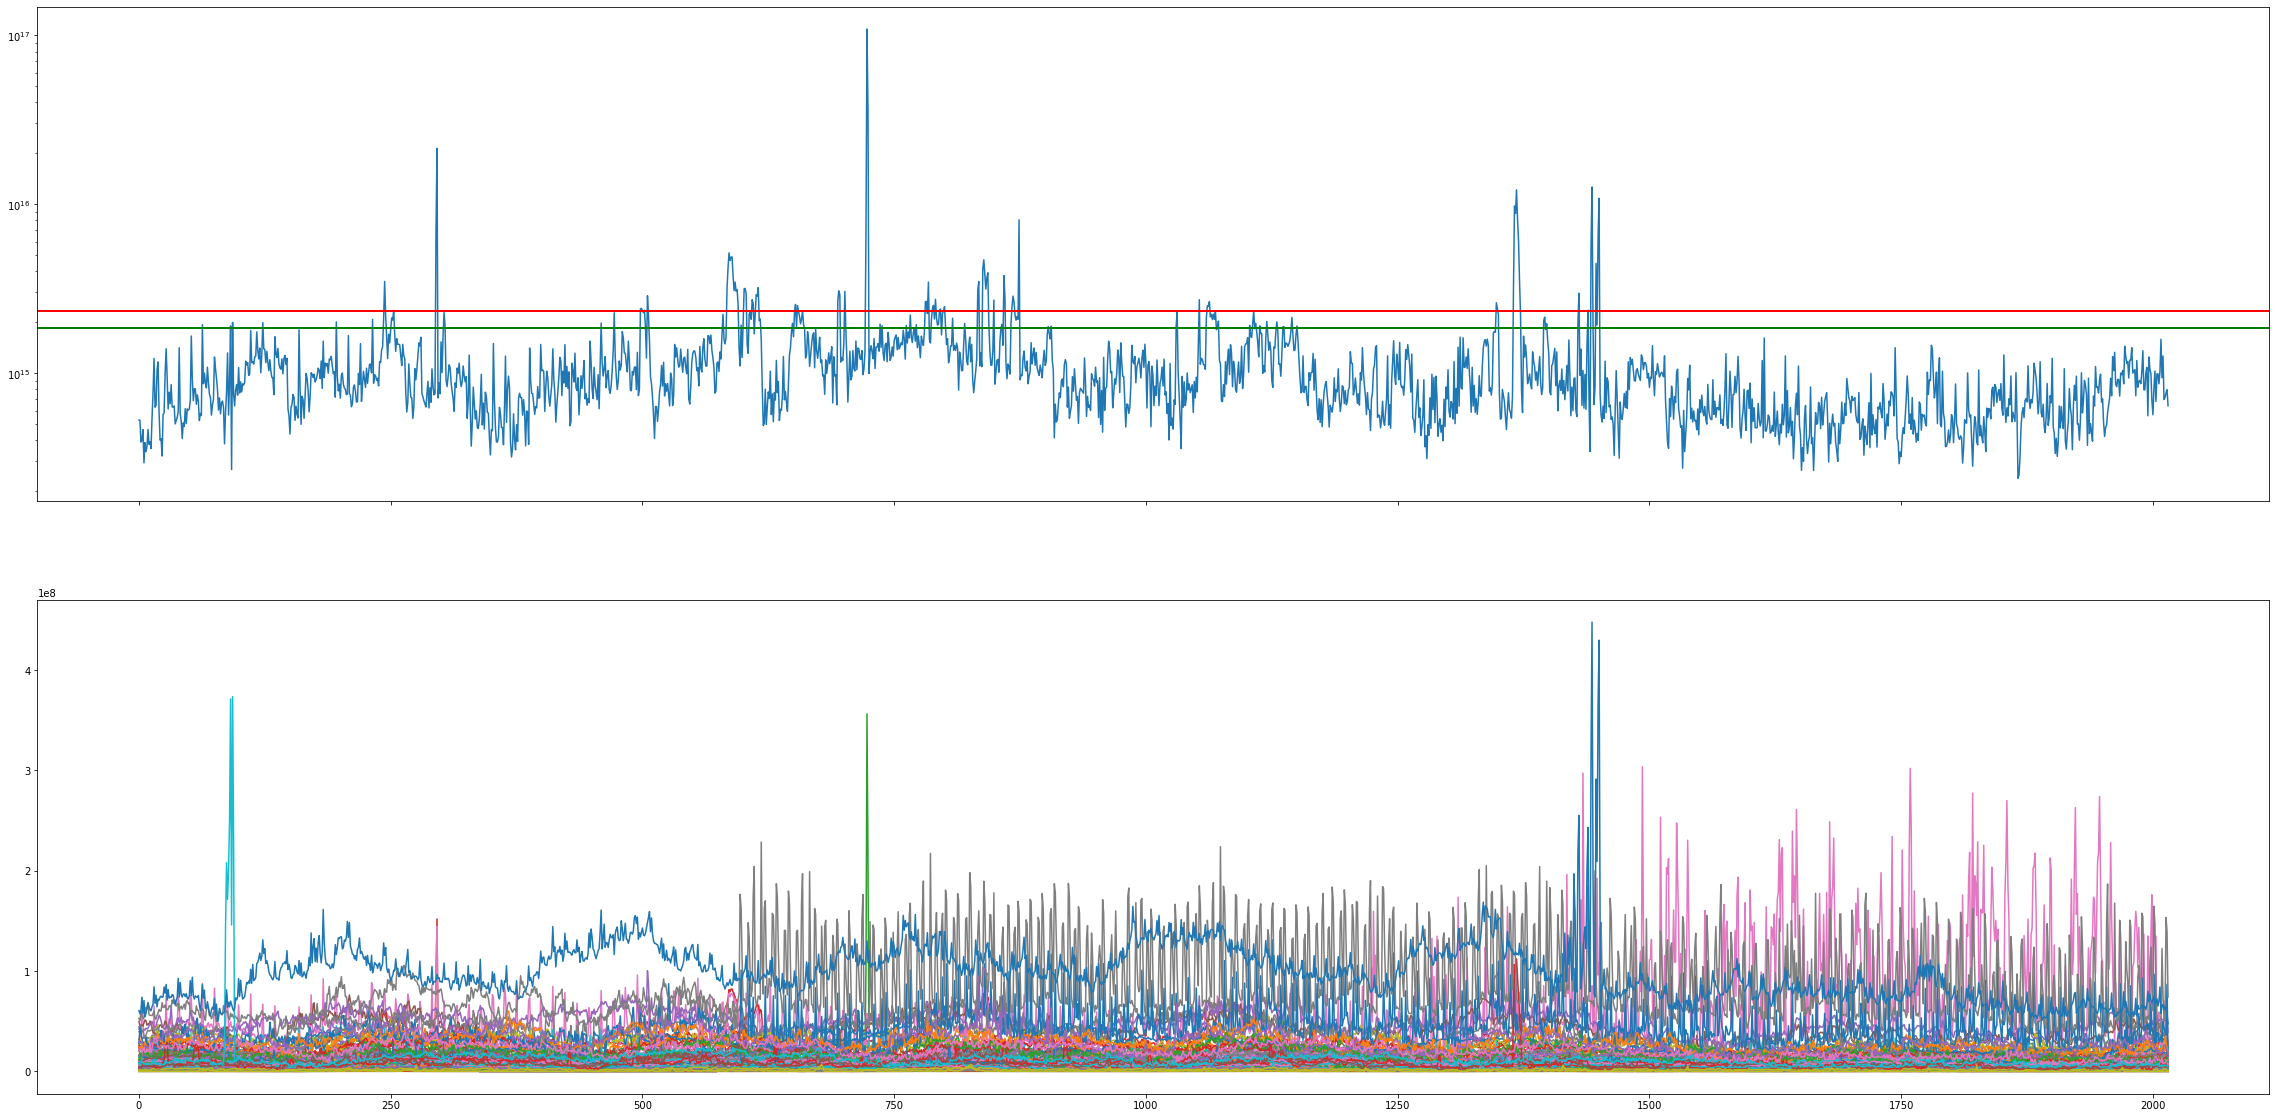

In [99]:
q_plot(X2, X2_resid, pc_const) # your code here

Число выбросов для $\alpha = 0.01$

In [94]:
([q_stat(X2_resid, t) for t in np.arange(X2_resid.shape[1])]  > q_critical(X2, pc_const, 0.01)).sum() # your code here

86

Число выбросов для $\alpha = 0.05$

In [95]:
([q_stat(X2_resid, t) for t in np.arange(X2_resid.shape[1])]  > q_critical(X2, pc_const, 0.05)).sum()# your code here

173

### Для недели $X3$

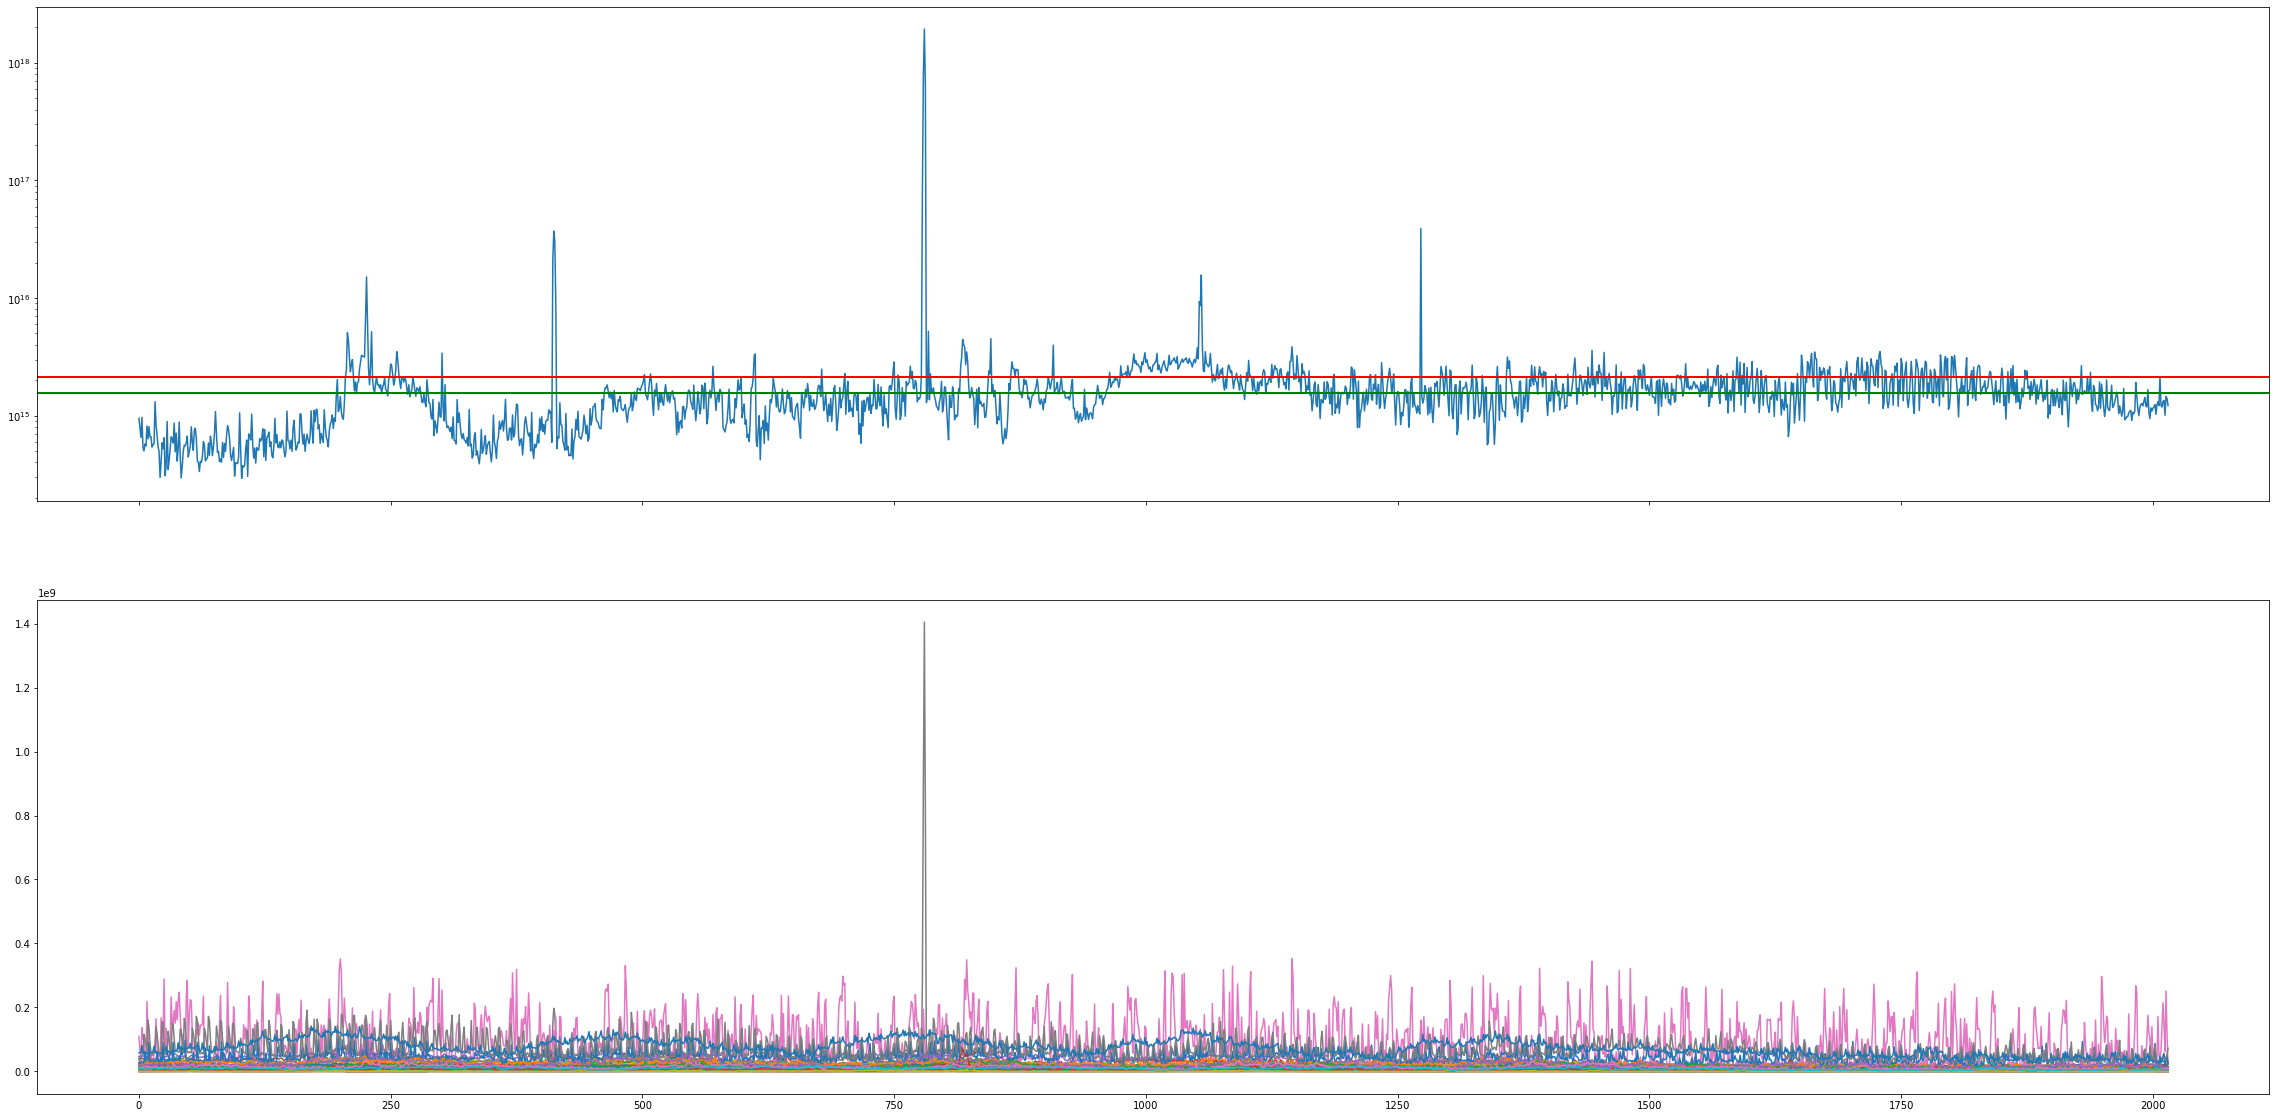

In [100]:
q_plot(X3, X3_resid, pc_const) # your code here

Число выбросов для $\alpha = 0.01$

In [96]:
([q_stat(X3_resid, t) for t in np.arange(X3_resid.shape[1])]  > q_critical(X3, pc_const, 0.01)).sum() # your code here

376

Число выбросов для $\alpha = 0.05$

In [97]:
([q_stat(X3_resid, t) for t in np.arange(X3_resid.shape[1])]  > q_critical(X3, pc_const, 0.05)).sum() # your code here

911

### Для недели $X4$

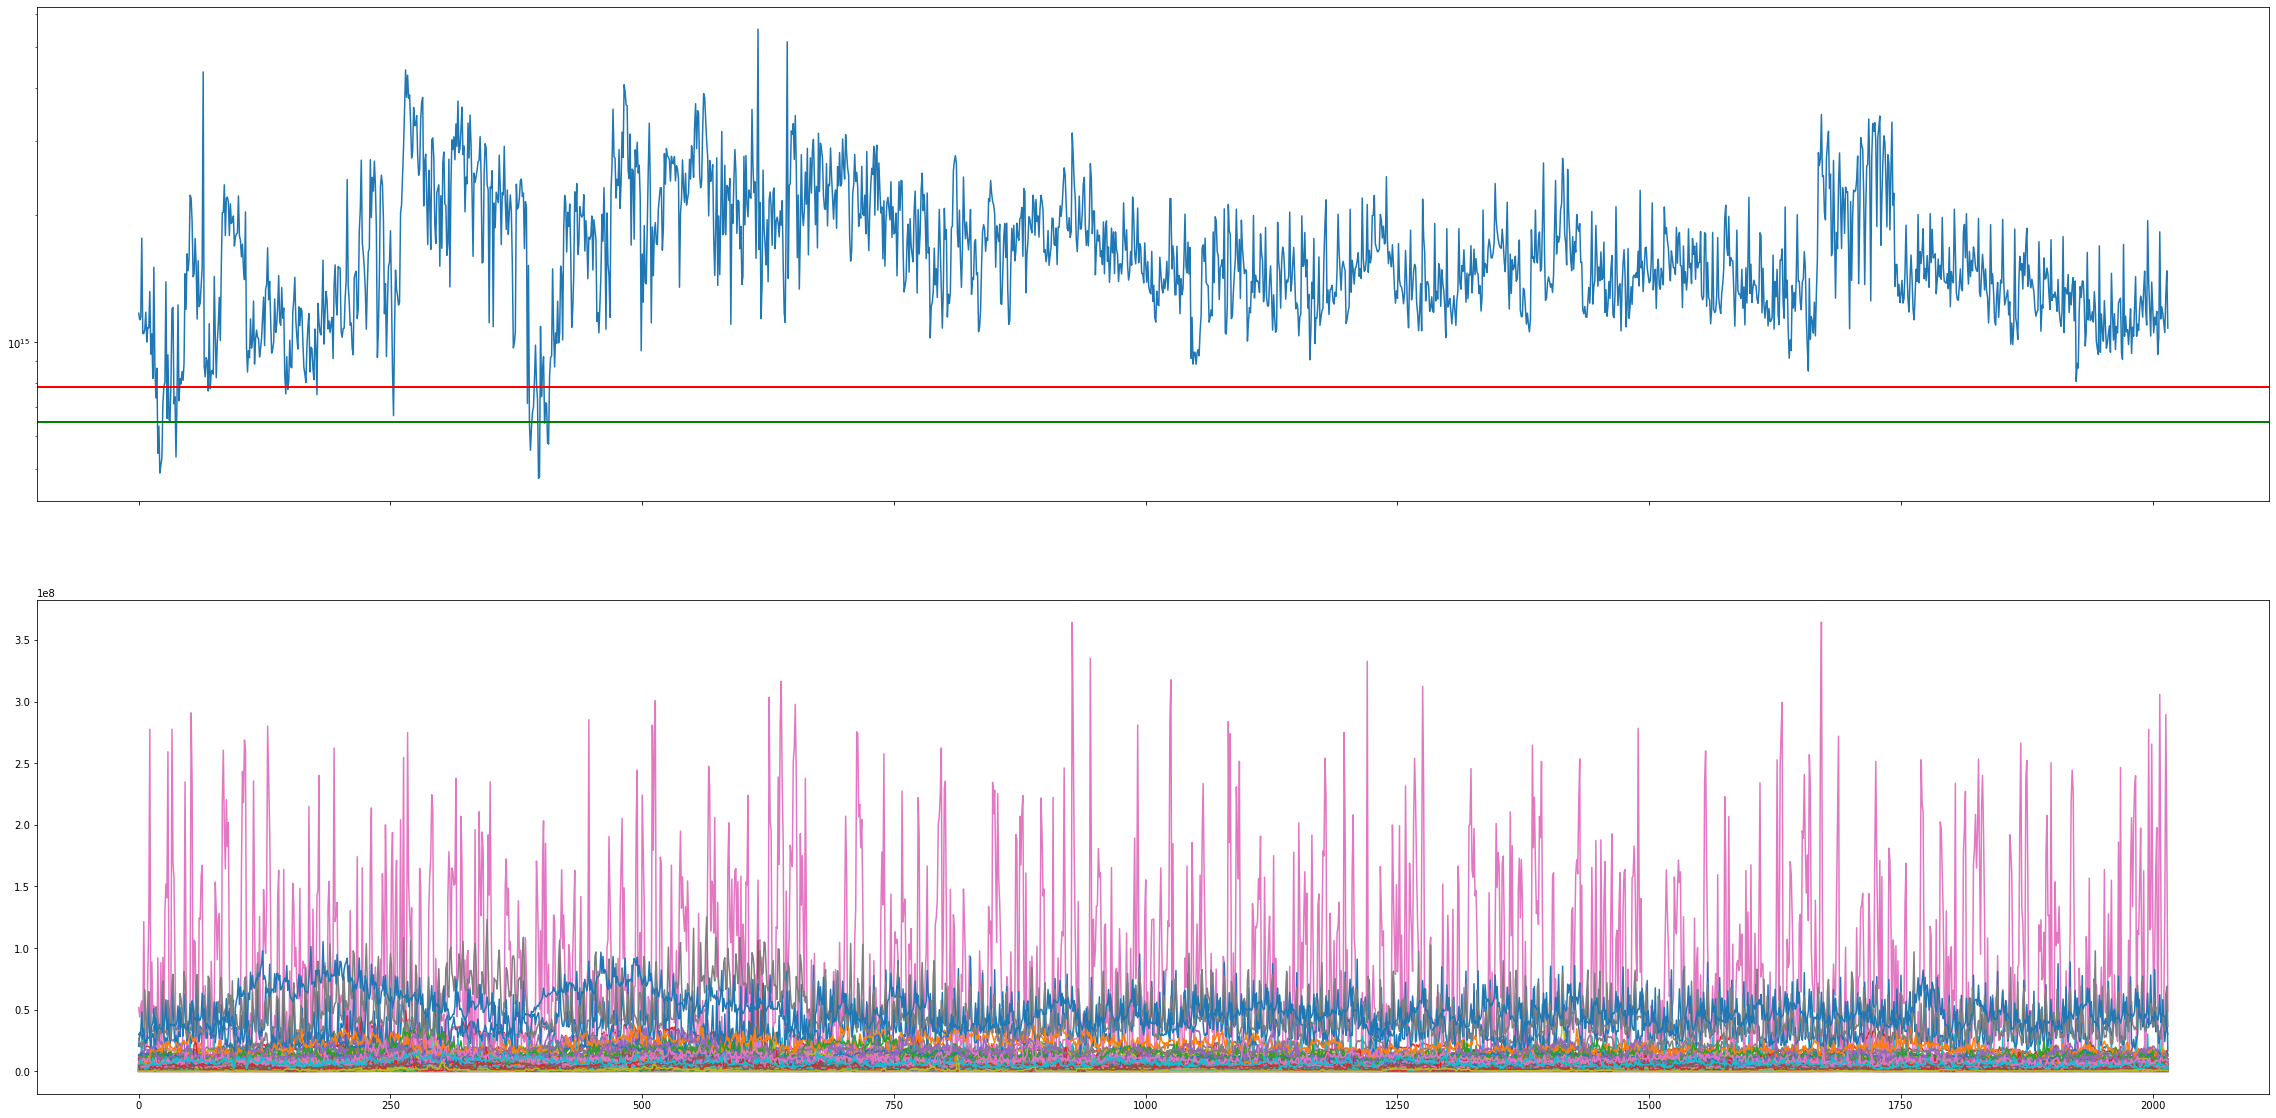

In [101]:
q_plot(X4, X4_resid, pc_const) # your code here

Число выбросов для  $\alpha=0.01$

In [ ]:
# your code here

Число выбросов для $\alpha = 0.05$

In [ ]:
# your code here

# Часть 2. Детектирование аномалий на основе One-Class SVM
Рассмотрим задачу детектирование сетевых атак: Intrusion Detection. Будем использовать данные из KDD Cup 1999 Competition ( http://kdd.ics.uci.edu/databases/kddcup99/task.html). Полная база данных содержит около пяти миллионов записей о сетевых соединениях и различных типах атаках. Mы будем работать подвыборкой в 10% от оригинального датасета, отсутствие атаки обозначено как “normal”, а ее наличие — как “abnormal”.

In [7]:
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split

from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD as TSVD

Считаем данные:

In [8]:
train = pd.read_csv('intrusion/train')
test = pd.read_csv('intrusion/test', delimiter = ';')
X_test = np.array(test.drop(test.columns[[0, 1, 2, 3]], axis=1))
np.save('test_np', X_test)

In [9]:
train.head(n=10)

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,...,9.1,1.00.1,0.00.6,0.11.1,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,210,624,0,0,0,0,...,109,1.0,0.0,0.06,0.05,0.0,0.0,0.0,0.0,normal.


В выборке метками $\{-1, 1\}$ обозначены аномальныe и нормальные наблюдения. Посмотрим на гистограмму классов:

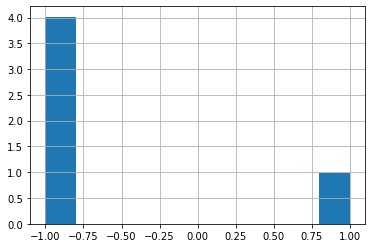

In [10]:
y_train = (train['normal.'] == 'normal.') * 2 - 1
plt.hist(y_train, density=True);
plt.grid(True)

"Отрежем" не нужные для обучения колонки и целевую переменную.

In [11]:
X_train = train.drop(train.columns[[0, 1, 2, 3, 41]], axis=1)
y_train = y_train

Посмотрим на признаки. Самый простой способ оценить их качество, это посчитать дисперсию:

In [12]:
X_train.var()

181        9.765770e+11
5450       1.091644e+09
0.1        4.453072e-05
0.2        1.817249e-02
0.3        3.036300e-05
0.4        6.116857e-01
0.5        2.408584e-04
1          1.262687e-01
0.6        3.233984e+00
0.7        1.113194e-04
0.8        6.072508e-05
0.9        4.051043e+00
0.10       9.296040e-03
0.11       1.214409e-04
0.12       1.330916e-03
0.13       0.000000e+00
0.14       0.000000e+00
0.15       1.384664e-03
8          4.543170e+04
8.1        6.067489e+04
0.00       1.449456e-01
0.00.1     1.451739e-01
0.00.2     5.364954e-02
0.00.3     5.389232e-02
1.00       1.506913e-01
0.00.4     6.757756e-03
0.00.5     2.027708e-02
9          4.191872e+03
9.1        1.124453e+04
1.00.1     1.687412e-01
0.00.6     1.193758e-02
0.11.1     2.316586e-01
0.00.7     1.775183e-03
0.00.8     1.448513e-01
0.00.9     1.450999e-01
0.00.10    5.317162e-02
0.00.11    5.296467e-02
dtype: float64

In [13]:
X_train.shape

(494020, 37)

Видим, что есть два константных признака. Их можно удалить:

In [14]:
idx = np.where(X_train.var() == 0)[0]
cols = X_train.columns[idx]
X_train.drop(cols, axis=1, inplace=True)

Следующее, что можно сделать, это посмотреть попарные корреляции признаков:

<Figure size 360x360 with 0 Axes>

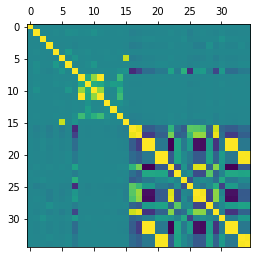

In [15]:
plt.figure(figsize=(5,5));
plt.matshow(X_train.corr());

Такая структура обещает эффективное снижение размерности.

### Задание 1 [1 балл] <a id="task2_1"></a>
Оцените с помощью randomized SVD количество компонент достаточных для сжатия и дальнейшего ускорения обучения. (randomized SVD - быстрый способ оценки количества компонент)

In [ ]:
X_train = np.array(X_train)
look_on_components =  # your code here
U, Sigma, VT =  # your code here
plt.plot(Sigma);

### Задание 2 [1 балл] <a id="task2_2"></a>

Выберите количество компонент для сжатия и примените **truncated SVD**

In [ ]:
model =  # your code here
X_train_proj =  # your code here

### Задание 3 [3 балла] <a id="task2_3"></a>

Проведите подбор параметров $\nu$ и $\gamma$ для модели OneClassSVM.

Подбор сразу двух параметров может быть затруднен с вычислительной точки зрения (занимает много времени на слабых ПК). В таком случае возможны два выхода:

1) Проводить раздельный подбор гиперпараматров. Сначала поиск по $\nu$, затем при оптимальном $\nu_{opt}$ провести поиск по $\gamma$

2) Уменьшить размер датасета

Поиск параметров предллагается провести в следующей области параметров:

$\nu$: [0.5,1]

$\gamma$: [0.1, 1]


In [ ]:
# количество обьектов для сокращения выборки
# перед уменьшением выборки дайте шанс обучению на полном датасете
subsample_N = X_train_proj.shape[0] # вместо этого укажите свое N

X_subsample = X_train_proj[0:subsample_N]
y_subsample = y_train[0:subsample_N]

print(X_train_proj.shape)
print(X_subsample.shape)

#### Проведем поиск по первому параметру $\nu$:

In [ ]:
scores = {'accuracy_score': make_scorer(accuracy_score),}

model =  # your code here

grid = {
    'nu':  # your code here
}

search = GridSearchCV(model, grid, scoring=scores,
                      n_jobs=-1, cv=2,
                      refit='accuracy_score')

search.fit(X_subsample, y_subsample)

#### Построим результаты валидации:

In [ ]:
 # your code here
print("nu:     ", search.cv_results_['param_nu'].data)
print("scores: ", search.cv_results_['mean_test_accuracy_score'])

Выберите $\nu$, обеспечивающее наибольший score на кроссвалидации, за исключением $\nu=1$, т.к. это противоречит физическому смыслу задачи

In [ ]:
score =  # your code here

nu_opt = score[score < 0.8].max()
print(nu_opt)

Теперь необходимо подобрать $\gamma$. Оптимальнее конечно было бы подбирать сразу оба параметра, но если это не возможно для ваших ресурсов в силу вычислительной сложности, то проведите отдельный поиск $\gamma$ при найденном ранее $\nu_{opt}$.

# Задание 
+ Используя кроссвалидацию оценить качество определения аномальных наблюдений с помощью обученной модели One-Class SVM 
+ Исследовать зависимость этого качества от параметров метода (ширина ядра, доля выбросов в модели, задаваемая параметром $\nu$)

In [ ]:
model = # your code here

grid = {
    'gamma': # your code here
}

search = GridSearchCV(model, grid, scoring=scores,
                      n_jobs=-1, cv=2,
                      refit='accuracy_score')

search.fit(X_subsample, y_subsample)

In [ ]:
# your code here
print("gamma:     ", search.cv_results_['param_gamma'].data)
print("scores: ", search.cv_results_['mean_test_accuracy_score'])